<a href="https://colab.research.google.com/github/mkorlyakova/test-face-recognition/blob/main/%D1%82%D0%B5%D1%81%D1%82_hypothesis_lfw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Импорт рабочих библиотек**

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2 as cv
import tarfile


In [ ]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import scipy.stats as st


In [ ]:
import seaborn as sns

Подключение к диску с данными

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


Метрики:

In [ ]:
# https://habr.com/ru/post/317798/

def calc_metrics(targets_scores, imposter_scores):
    """
    targets_scores - значения выхода модели через метрику для пар, 
    imposter_scores - значения выхода модели через метрику для не пар,
    """
    # диапазоны
    min_score = np.minimum(np.min(targets_scores), np.min(imposter_scores))
    max_score = np.maximum(np.max(targets_scores), np.max(imposter_scores))
    print(min_score,max_score)
    n_tars = len(targets_scores)
    n_imps = len(imposter_scores)

    N = 100

    fars = np.zeros((N,))
    frrs = np.zeros((N,))
    dists = np.zeros((N,))

    mink = float('inf')
    eer = 0
    min_i = 0
    # поиск оптимальной точки
    for i, dist in enumerate(np.linspace(min_score, max_score, N)):
        far = len(np.where(imposter_scores > dist)[0]) / n_imps
        frr = len(np.where(targets_scores < dist)[0]) / n_tars
        # добавили оценки по этому порогу для dist
        fars[i] = far
        frrs[i] = frr
        dists[i] = dist

        k = np.abs(far - frr)

        if k < mink:
            mink = k
            min_i = i
            eer = (far + frr) / 2
    # accuracy

    if n_tars>n_imps:
      nn = n_imps
    else:
      nn = n_tars
    TN = np.sum(imposter_scores[:nn] > dists[min_i]) 
    TP = np.sum(targets_scores[:nn] < dists[min_i])
    acc = (TP+TN)/(nn*2)


    return eer, fars, frrs, dists, min_i, acc

# вычисление метрики для вложеня (Euqlid)
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5
# cos
def diffc(e1, e2):
    return 1 - np.sum((e1 * e2))/np.sum( (e1**2)) ** 0.5/np.sum( (e2**2)) ** 0.5

# метрики по эмбедингу (вложению)
def my_embed_metric(X,L):
  net_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  label_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  for i in range(X.shape[0]-1):
    for j in range(i+1,X.shape[0]):
      net_dist[i,j] = diff( X[i,:],X[j,:])
      net_dist[j,i] =  net_dist[i,j]
      label_dist[i,j] = int(L[i] == L[j])
      label_dist[j,i] =  label_dist[i,j]


def image_clast_net(n_emb,l_dist,    verbose=1):
  '''
  полный цикл  анализа
  вход:
    n_emb, - расстояния
    l_dist, - метки
  
  гиперпараметры алгоритма:

,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)


  
  ''' 

  # строим метрики
  if 1:

      # анализ 
      # делим по меткам пар на похожие и нет пары 
      Dist1 = []
      Dist0 = []
      for i in range(n_emb.shape[0]):
          if l_dist[i] :
            Dist1.append(n_emb[i])
          else:
            Dist0.append(n_emb[i])  
      if verbose:
        plt.figure(figsize = (16,5))
        plt.subplot(1,2,1)
        plt.hist(Dist0,alpha = 0.5,bins = 100, label = 'labeli!=labelj : 0')
        plt.hist(Dist1,alpha = 0.5,bins = 100, label = 'labeli==labelj : 1')
        plt.legend()
      
        plt.grid(True)
        plt.title('распределение рaсстояний по типам пар')
        plt.subplot(1,2,2)
        sns.kdeplot(Dist0,)
        sns.kdeplot(Dist1)
        plt.grid(True)
        plt.legend()
        plt.title('распределение рaсстояний по типам пар')
        plt.show()
      # среднее по выборке расстояние
      m0 = np.mean(Dist0)
      m1 = np.mean(Dist1)
      print('средняя дистанция по 0:',m0)
      print('средняя дистанция по 1:',m1)
      # std по выборкам
      d0 = np.std(Dist0)
      d1 = np.std(Dist1)
      # проверим сходство непараметрическими тестами
      L1 = len(Dist1)
      L0 = len(Dist0)
      if L1>L0:
        L_d01 = L0
      else:
        L_d01 = L1  
      print('std по 0:',d0)
      print('std по 1:',d1)
      conf_int0 = st.t.interval(0.99, len(Dist0)-1, loc=np.mean(Dist0), scale=st.sem(Dist0))
      conf_int1 = st.t.interval(0.99, len(Dist1)-1, loc=np.mean(Dist1), scale=st.sem(Dist1))
      print('доверит.интервал 0',conf_int0)
      print('доверит.интервал 1',conf_int1)
      print('интервал 3 sigms 0',[m0-d0*3,m0+d0*3])
      print('интервал 3 sigma 1',[m1-d1*3,m1+d1*3])
      if verbose:
        plt.plot([0,0,0],[conf_int0[0],m0,conf_int0[1]],'-og', label='0')
        plt.plot([1,1,1],[conf_int1[0],m1,conf_int1[1]], '-ok',label='1')
        plt.plot([0,0,0],[m0-d0,m0,m0+d0],'--xb', label='+-sigma 0')
        plt.plot([1,1,1],[m1-d1,m1,m1+d1], '--xr',label='+-sigma 1')
        plt.legend()
        plt.title('доверит.интервал по типам пар и +-sig')
        plt.show()
      wc = wilcoxon(Dist1[:L_d01],Dist0[:L_d01])[1]
      mu = mannwhitneyu(Dist1,Dist0)[1]
      print('тест Мана-Уитни p_value:', mu)
      print('тест Вилкокса p_value:', wc)
      stat_rez = [m0,m1,d0,d1,conf_int0[0],conf_int0[1],conf_int1[0],conf_int1[1],mu,wc,m0-d0*3,m0+d0*3,m1-d1*3,m1+d1*3]
      
      eer, fars, frrs, dists, min_i, acc = calc_metrics(Dist1,Dist0)
      plt.plot(fars,frrs)
      plt.plot(fars[min_i],frrs[min_i],'or')
      plt.grid(True)
      plt.legend()
      plt.title('FAR/FRR')
      plt.xlabel('FAR')
      plt.ylabel('FRR')
      plt.show()

  return  stat_rez, eer,acc

Загрузить модели:

In [ ]:
path_c = '/gdrive/MyDrive/Face recognition/'

## *Гипотеза 1 тест:*

Схема сети для эмбединга: 

 - layer[0] сверточных блоков (С-С-MP)
 - layer[1] полносвязных блоков (FC-Drop)

In [ ]:
rand_project1 = keras.models.Sequential([keras.layers.Conv3D(64,3,1,padding='same',activation='relu', input_shape = (1,32,32,1)),
                                        
                                        keras.layers.Embedding(32*32*64,64,input_length=1),
                                        keras.layers.Flatten(), 
                                        keras.layers.Dense(32),keras.layers.Dense(25),keras.layers.Softmax( )])
rand_project1.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=False),metrics =['accuracy'])
mod1 = keras.models.Model(rand_project1.inputs,rand_project1.layers[-3].output)

mod1.load_weights(path_c+'LRP_net.h5')

In [ ]:
def rand_class(levels_c = [64,32,32],level_d = [32,25] ):
  """
  передаем список числа фильтров в свертках -levels_c
  передаем список числа нейронов в плотных слоях -levels_d 
  """
  rand_project = keras.models.Sequential([keras.layers.Conv3D(levels_c[0],3,1,padding='same',activation='relu', input_shape = (1,32,32,1))])
  for i in levels_c[1:]:
    rand_project.add(keras.layers.Conv2D(i,3,1,padding='same',activation='relu'))
    rand_project.add(keras.layers.Conv2D(i,3,2,padding='same',activation='relu'))
  rand_project.add(keras.layers.Flatten())
  for i in level_d:
    rand_project.add(keras.layers.Dense(i))
    
  rand_project.add(keras.layers.Dense(level_d[1],activation='sigmoid'))
  rand_project.add(keras.layers.Dense(level_d[1]))
  rand_project.add(keras.layers.Softmax( ))
  
  rand_project.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=False),metrics =['accuracy'])
  # Свертки не обучаем
  for i in range(3):
    rand_project.layers[i].trainable = False

  return rand_project


conv = [16,8,16,16]
den = [128,30]
rand_project2 = rand_class(levels_c = conv,level_d = den )
rand_project2.load_weights(path_c+'rand_net_.h5')

mod2 = keras.models.Model(rand_project2.inputs,rand_project2.layers[-3].output)

## *Гипотеза* 2 тест: 
  **metric lening**

###  Реализация:
 - проводим массивный тест:     
 - анализ результат (метрики): accuracy, EER, FAR,FRR





In [ ]:
NUM_EPOCHS =5 # число эпох 
NUM_BATCH = 40 # число пакетов

LEARNING_RATE = 0.001 # скорость обучения

# оптимизатор
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# зазор
MARGIN = 100.0

In [ ]:
# Custom model Class
# делаем обучение по SiamNet

class CustomModel(tf.keras.Model):
    def calc_metrics(self, targets_scores, imposter_scores):
      """
          
      targets_scores - значения выхода модели через метрику для пар, 
      imposter_scores - значения выхода модели через метрику для не пар,
    
      
      """
      # диапазоны

      min_score = np.minimum(np.min(targets_scores), np.min(imposter_scores))
      max_score = np.maximum(np.max(targets_scores), np.max(imposter_scores))
      print(min_score,max_score)
      n_tars = len(targets_scores)
      n_imps = len(imposter_scores)
      # число точек
      N = 100
      # создаем метрики
      fars = np.zeros((N,))
      frrs = np.zeros((N,))
      dists = np.zeros((N,))

      mink = float('inf')
      eer = 0
      min_i = 0
      # поиск оптимальной точки
      for i, dist in enumerate(np.linspace(min_score, max_score, N)):
        far = len(np.where(imposter_scores > dist)[0]) / n_imps
        frr = len(np.where(targets_scores < dist)[0]) / n_tars
        # добавили оценки по этому порогу для dist
        fars[i] = far
        frrs[i] = frr
        dists[i] = dist

        k = np.abs(far - frr)

        if k < mink:
          mink = k
          min_i = i
          eer = (far + frr) / 2
      
      # accuracy

      if n_tars>n_imps:
        nn = n_imps
      else:
        nn = n_tars
      TN = np.sum(imposter_scores[:nn] > dists[min_i]) 
      TP = np.sum(targets_scores[:nn] < dists[min_i])
      acc = (TP+TN)/(nn*2)


      return eer, fars, frrs, dists, min_i, acc
    
    # Функция потерь Contrastiv 
    def contastive_loss(self,embs, labels):
      #print(embs.shape,labels.shape)
      bs = embs.shape[0]
      embs1 = embs[:bs//2, :]
      embs2 = embs[bs//2:, :]
  
      labels1 = labels[:bs//2]
      labels2 = labels[bs//2:]
      #print(labels1,labels2)
      d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
      d =  tf.sqrt(d2)
      z = tf.cast(labels1 == labels2, tf.float32)
      #print(z.dtype,d.dtype, d2.dtype)
      MARGIN = 100.0
      return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0.0, MARGIN - d)**2)

    # https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
    # Функция потерь - родной из tf как-то неправильно обработал мой тензор - делаю свою
    def loss_cos(self,embs, labels):
      # print(embs,labels)
      bs = embs.shape[0]
      embs1 = embs[:bs//2, :]
      embs2 = embs[bs//2:, :]
      #print(embs1,embs2)
      labels1 = labels[:bs//2]
      labels2 = labels[bs//2:]
      #print(labels1,labels2)
 
      d2 =tf.reduce_sum(embs1 * embs2, axis =-1 )/tf.reduce_sum( embs1 ** 2, axis = -1) / tf.reduse_sum( embs2 ** 2, axis = -1)
      #print(d2.shape)
      d =  tf.abs(d2 - 1)
      z = tf.cast(labels1 == labels2, tf.float64)
      print(z.dtype(),d.dtype)
      return tf.reduce_mean(z * d + (1-z)*(d2))   
    #  Для получения оценок L2  
    def my_embed_metric(self, X,L):
      
      net_dist = tf.ones( (X.shape[0],X.shape[0]),dtype=tf.float32) # нормированное расстояние - инициализация 1(пока)
      label_dist = tf.ones((X.shape[0],X.shape[0]),dtype=tf.int8) # нормированное расстояние - инициализация 1(пока)
      for i in range(X.shape[0]-1):
        for j in range(i+1,X.shape[0]):
          net_dist[i,j] = tf.reduce_sum( tf.square(tf.cast(X.numpy()[i:i+1,:],dtype = tf.float32)- tf,cast(X.numpy()[j:j+1,:],dtype = tf.float32)), axis=-1)( )
          net_dist[j,i] =  net_dist[i,j]
          label_dist[i,j] = tf.cast(L[i] == L[j],dtype=tf.int8)
          label_dist[j,i] =  label_dist[i,j]
      return net_dist, label_dist      
    
    #Шаг обучения нейронки
    def train_step(self, data):
        # получить данные из data
        # oделаем прямой проход
        image, label = data
        #print(image.shape)      
        with tf.GradientTape() as tape:
            y_pred = self(image, training=True)  # Forward pass
            #print(y_pred.shape)
            # строим потери
            loss = self.contastive_loss(y_pred, label)

        # строим Градиент
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # адаптация
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # метрика
        '''
        
        y_pred = self(image, training=True)
        print(y_pred.shape,y_pred[:2,:5])
        n_d,n_l = my_embed_metric( y_pred.numpy(),label.numpy())
        ind1 = tf.where(n_l == 1)
        ind0 = tf.where( n_l == 0)
        print(ind1.shape)
        targets_scores = n_d[ind1,:]
        imposter_scores = n_d[ind0,:]
        eer, fars, frrs, dists, min_i, acc = self.calc_metrics(targets_scores, imposter_scores)
        '''
 
        #self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {'dist':loss}

In [ ]:
def net_creat_c(EMB_SIZE = 64, im_size = (32,32,1),X_size = 8, layer = [5,3], numb_neuro = 1, loss = 'mse', opt = 'Adam', metrics = ['accuracy']):
  # поток I
  inp_x_im = tf.keras.layers.Input(shape=(im_size[0], im_size[1], im_size[2]))
  
  x1 = tf.keras.layers.Conv2D(32*numb_neuro, (3, 3), padding='same', activation='relu')(inp_x_im)
  for k in range(layer[0]):
    x2 = x1
    x1 = tf.keras.layers.Conv2D(64*numb_neuro, (3, 3), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(64*numb_neuro, (3, 3), padding='same', activation='relu')(x1)
    x1  = tf.keras.layers.concatenate([x1,x2])
    x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
    
  x1 = tf.keras.layers.Flatten()(x1)
  # поток Х 
  x = tf.keras.layers.Dense(256, activation='relu')(x1)
  x = tf.keras.layers.Dropout(0.5)(x)
  for k in range(layer[1]):
    x = tf.keras.layers.Dense(EMB_SIZE*numb_neuro, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
  # Выход эмбединга  
  x = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)


  model = CustomModel( inputs =inp_x_im, outputs = x)
  model.compile(optimizer=opt,loss=loss,metrics=metrics)
  return model

In [ ]:
mod3 = net_creat_c(EMB_SIZE = 64, im_size = (32,32,1),X_size = 8,  layer = [1,2], numb_neuro=1)
mod3.load_weights(path_c+'siam_net_rez_.h5')

# Реализация теста:
проводим массивный тест: LFW

анализ результат (метрики): 
  - accuracy, 
  - EER, 
  - FAR,FRR

Запуск : 
  - читаем каталог примеров на диск
  - задаем размер картинок

In [ ]:
# Посмотреть на данные
import tarfile

zipfile = path_c+'lfw.tar.gz'
if zipfile.endswith("tar.gz"):
    tar = tarfile.open(zipfile, "r:gz")
elif zipfile.endswith("tar"):
    tar = tarfile.open(zipfile, "r:")
ll = tar.getmembers( )
tar.extractall(  )    

tar.close()

In [ ]:
label = []
path_train = '/content/lfw/negative/'
dir_list = os.listdir(path_train)
m = 0
for name in dir_list:
    folder_list = os.listdir(path_train+name+'/')
    image = []
    image2 = []

    if len(folder_list)>0:
      
      for i,k in enumerate(folder_list):
        
        img = cv.imread(path_train+name+'/'+k,   )
        img = cv.resize(img,(32,32))
        imgl = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        
        image.append(imgl.reshape(-1,32,32,1))
        image2.append(imgl.reshape(32,32,1))
      y1 = mod1.predict(np.array(image))
      y2 =mod2.predict(np.array(image))
      y3 =mod3.predict(np.array(image2))
      label.append([diff(y1[0,:], y1[1,:]),diff(y2[0,:], y2[1,:]),diff(y3[0,:], y3[1,:])])  

L0 = pd.DataFrame(np.array(label).reshape(-1,3),columns = ['dist mod','dist rand','dist siam'])

L0['label'] =0
L0.head()
L0.to_csv(path_c+'H012.rez')     
      

In [ ]:




label = []
path_train = '/content/lfw/positive/'
dir_list = os.listdir(path_train)
m = 0
for name in dir_list:
    folder_list = os.listdir(path_train+name+'/')
    image = []
    image2 = []
    if len(folder_list)>0:
      
      for i,k in enumerate(folder_list):
        
        img = cv.imread(path_train+name+'/'+k,   )
        img = cv.resize(img,(32,32))
        imgl = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        
        image.append(imgl.reshape(-1,32,32,1))
        image2.append(imgl.reshape(32,32,1))
      y1 = mod1.predict(np.array(image))
      y2 =mod2.predict(np.array(image))
      y3 =mod3.predict(np.array(image2))
      label.append([diff(y1[0,:], y1[1,:]),diff(y2[0,:], y2[1,:]),diff(y3[0,:], y3[1,:])])

L1 = pd.DataFrame(np.array(label).reshape(-1,3),columns = ['dist mod','dist rand','dist siam'])
L1['label'] =1
L1.head()

L0 = pd.concat([L0,L1])
L0.head()
L0.to_csv(path_c+'H012.rez')

In [ ]:
L0.head()

,dist mod,dist rand,dist siam,label
0,27.355367,2.085671,0.949385,0
1,36.740424,3.768841,2.676939,0
2,34.667037,3.895053,2.540372,0
3,30.318393,3.581943,4.245723,0
4,31.682214,3.360122,1.660059,0


No handles with labels found to put in legend.


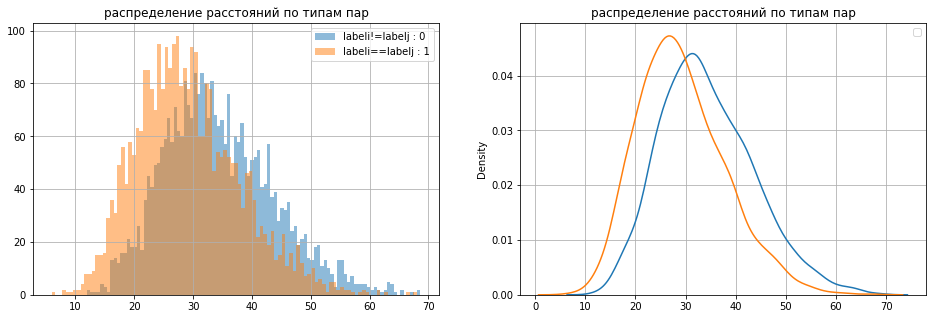

средняя дистанция по 0: 34.3734731693875
средняя дистанция по 1: 29.204078400100805
std по 0: 9.309832262955357
std по 1: 8.747447698034719
доверит.интервал 0 (33.935298579444634, 34.81164775933037)
доверит.интервал 1 (28.79237288276463, 29.61578391743698)
интервал 3 sigms 0 [6.4439763805214305, 62.30296995825357]
интервал 3 sigma 1 [2.9617353059966476, 55.44642149420496]


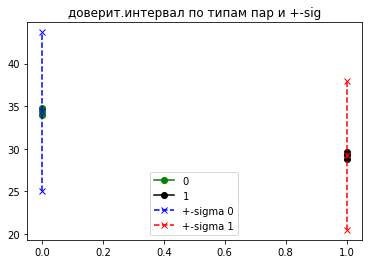

No handles with labels found to put in legend.


тест Мана-Уитни p_value: 7.962426635372943e-102
тест Вилкокса p_value: 7.767262997027163e-97
5.949077361562667 68.63655412752013


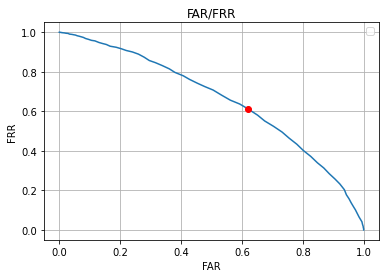

Accuracy для mod1: 0.6161666666666666
ERR для mod1: 0.6161666666666666


No handles with labels found to put in legend.


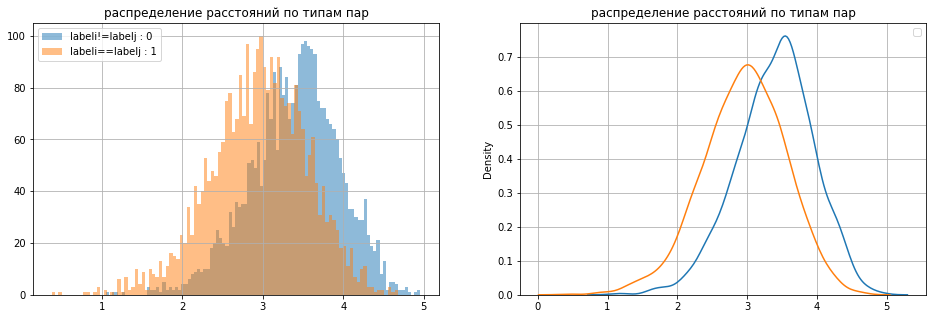

средняя дистанция по 0: 3.395528254292411
средняя дистанция по 1: 2.952982972948708
std по 0: 0.552746463438256
std по 1: 0.5975130205265442
доверит.интервал 0 (3.3695128065250906, 3.421543702059731)
доверит.интервал 1 (2.924860551903967, 2.9811053939934484)
интервал 3 sigms 0 [1.737288863977643, 5.053767644607179]
интервал 3 sigma 1 [1.1604439113690752, 4.74552203452834]


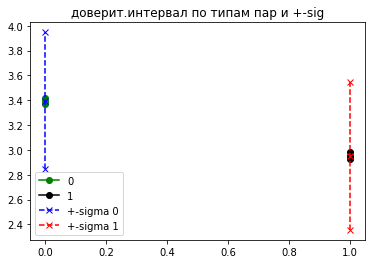

тест Мана-Уитни p_value: 8.12909912830298e-174
тест Вилкокса p_value: 6.49591814281799e-157
0.3725416147105233 4.960594730099804


No handles with labels found to put in legend.


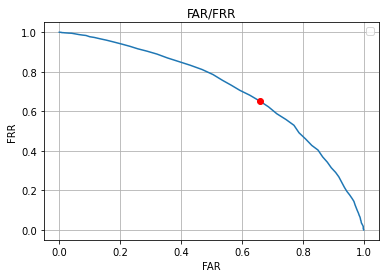

Accuracy для mod2: 0.6553333333333333
ERR для mod2: 0.6553333333333333


No handles with labels found to put in legend.


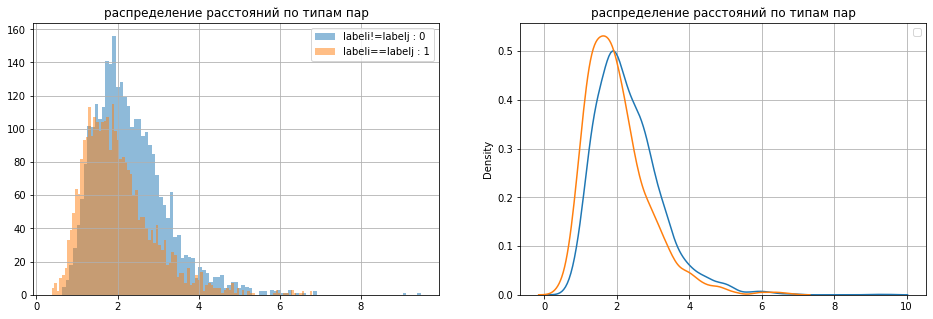

средняя дистанция по 0: 2.3181146709572054
средняя дистанция по 1: 2.0105030448352914
std по 0: 0.9153396146129689
std по 1: 0.8801270086265919
доверит.интервал 0 (2.275033490871134, 2.3611958510432767)
доверит.интервал 1 (1.96907917379122, 2.051926915879363)
интервал 3 sigms 0 [-0.42790417288170124, 5.0641335147961115]
интервал 3 sigma 1 [-0.6298779810444843, 4.650884070715067]


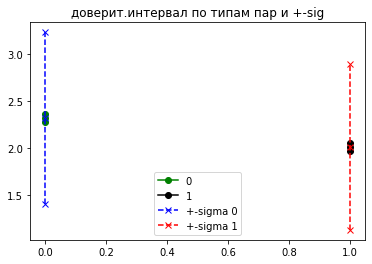

тест Мана-Уитни p_value: 1.5393539084301376e-49
тест Вилкокса p_value: 6.82359733905352e-45
0.3738973419939229 9.470354101696696


No handles with labels found to put in legend.


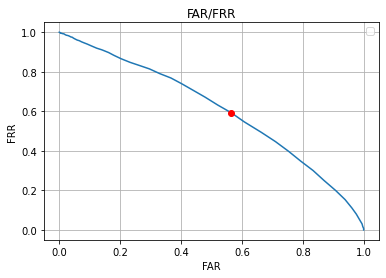

Accuracy для mod3: 0.5788333333333333
ERR для mod3: 0.5788333333333333


In [ ]:
stat_mod1, eer_mod1,acc_mod1 = image_clast_net(L0['dist mod'].values,L0.label.values,    verbose=1)
print('Accuracy для mod1:', acc_mod1)
print('ERR для mod1:', eer_mod1)
stat_mod2, eer_mod2,acc_mod2 = image_clast_net(L0['dist rand'].values,L0.label.values,    verbose=1)
print('Accuracy для mod2:', acc_mod2)
print('ERR для mod2:', eer_mod2)
stat_mod3, eer_mod3,acc_mod3 = image_clast_net(L0['dist siam'].values,L0.label.values,    verbose=1)
print('Accuracy для mod3:', acc_mod3)
print('ERR для mod3:', eer_mod3)

Резюме теста:

  - модель Эмбединг+классификация лучшая

In [ ]:
# Эксперимент результаты:

rez = pd.DataFrame(data = [stat_mod1+[acc_mod1],stat_mod2+[acc_mod2],stat_mod3+[acc_mod3]],index=['случ.проекция','случ.проекц+классификация','siamesNet'] , columns = ['m0','m1','d0','d1','conf_int0[0]','conf_int0[1]','conf_int1[0]','conf_int1[1]','mu','wc','m0 -3s0','m0+3s0','m1 -3s1','m1+3s1', 'acc']) 

rez.to_csv('/gdrive/MyDrive/Face recognition/rez_test.csv')
rez

,m0,m1,d0,d1,conf_int0[0],conf_int0[1],conf_int1[0],conf_int1[1],mu,wc,m0 -3s0,m0+3s0,m1 -3s1,m1+3s1,acc
случ.проекция,34.373473,29.204078,9.309832,8.747448,33.935299,34.811648,28.792373,29.615784,7.962427e-102,7.767263e-97,6.443976,62.302970,2.961735,55.446421,0.616167
случ.проекц+классификация,3.395528,2.952983,0.552746,0.597513,3.369513,3.421544,2.924861,2.981105,8.129099e-174,6.495918e-157,1.737289,5.053768,1.160444,4.745522,0.655333
siamesNet,2.318115,2.010503,0.915340,0.880127,2.275033,2.361196,1.969079,2.051927,1.539354e-49,6.823597e-45,-0.427904,5.064134,-0.629878,4.650884,0.578833
